#  ATOC5860 Application Lab #4 - fft_mesa - FFT Mesa Data
##### Written by Prof. Kay (CU), with "peer-review" by Dr. Elizabeth Maroon (formerly CU, now U-Wisconsin) Dr. Vineel Yettella (ATOC Ph.D. 2018)
##### last updated March 17, 2023 - works with environment atoc5860env2023clean.yml

### LEARNING GOALS:
1) Complete a spectral analysis using two different functions in Python (direct FFT from numpy and using scipy which has more options). Describe the results including an interpretation of the spectral peaks and an assessment of their statistical significance.
2) Contrast applying a Boxcar and a Hanning Window when calculating the power spectra. What are the advantages/disadvantages of these two window types?  What are the implications for the resulting power spectra? 
3) Compare spectral analysis of common atmospheric variables (temperature, humidity, wind).  Formulate a hypothesis for which variable will have the largest spectral power at diurnal and seasonal frequencies, and test it using spectral analysis.

### DATA and UNDERLYING SCIENCE MOTIVATION:  
In this notebook, you will analyze hourly surface met observations from Mesa Lab in Boulder Colorado for the years 2016-2021.  Raw data were munged from their original format into a single .csv file for analysis here (see github https://github.com/jenkayco/ATOC5860_Spring2023/tree/main/applicationlabs/lab4/mesadata_process).  Missing data are present in the dataset. The data are in .csv format and are called mesa_data_2016-2021_withmissing.csv.


### Non-exhaustive Questions to guide your analysis:  
**To Start - Execute all code without making any modifications.** 

1) Look at your data.  What are the autocorrelation and e-folding time of your data?  What spectral peaks do you expect to find in your analysis and how much power do you think they will have?

2) Calculate the power spectra using the Numpy method, which assumes a Boxcar window that is the length of your entire dataset.  Graph the power spectra, the red noise fit to the data, and the 99% confidence interval. What statistically significant spectral peaks did you find?  What do they represent?  How did you assess the statistical significance (what is the null hypothesis that you are trying to reject)?  Compare back to Barnes and Hartman notes to make sure all of the equations and functions in the notebook are working as you expect them too.

3) Calculate the power spectra using the scipy method.  Check that you get the same result as you got using the Numpy method.  Next – compare the power spectra obtained using both a Boxcar window and a Hanning window.   Assume a window length that is the entire length of the dataset. Do you get the same statistically significant peaks when applying the Hanning window and the Boxcar window?  How do they differ? Can you explain why?  

4) If time – take a look at other surface meteorological variables in the dataset.  Do you obtain similar spectral peaks?

Random Question: Are you seeing power at 12-hour frequencies when looking at temperature?  Maybe it is atmospheric tides? Or is it some kind of spectral ringing artifact?  Unsolved mysteries of ATOC5860 Objective Data Analysis…

In [1]:
#import modules
import numpy as np   #for calculations
import matplotlib.pyplot as plt  #for plotting
%matplotlib inline  
import pandas as pd  #for reading in data
import datetime    #for manipulation by dtae
import collections  #for additional dictionary functionality
from matplotlib.gridspec import GridSpec #for subplots
import scipy.signal as signal #for signal processing
import scipy.stats as stats

In [2]:
def create_normalized_redfit(data_length,Te):
    freq = np.arange(0,(data_length/2)+1,1)/float(data_length) # to Nyquist
    red_fit = (2 * Te)/(1 + ((2*np.pi*freq)**2)*(Te**2)) # After Hartmann 6.64, 6.91
    return red_fit/np.sum(red_fit)
def create_f_bounds(alpha,dof,red_fit_n):
    f_ratio = stats.f.ppf(alpha,dof,200) # Note: 200 = large degree of freedom for red noise
    return f_ratio*red_fit_n

In [3]:
## Read in the data
filename = 'mesa_data_2016-2021_withmissing.csv'
data_all=pd.read_csv(filename,sep=',')
data_all.head()

,day,hour_UTC,pres_mb,tdry_degC,rh_percent,wdir,wspd_m_per_s,wspdmax_m_per_s,raina_event_mm,year
0,2016-01-01,0.0,817.400024,-7.7,72.099998,316.0,2.2,3.0,0.0,2016
1,2016-01-01,1.0,817.599976,-8.1,74.699997,327.0,0.9,1.3,0.0,2016
2,2016-01-01,2.0,818.099976,-8.0,70.500000,227.0,1.7,2.8,0.0,2016
3,2016-01-01,3.0,818.500000,-8.1,69.599998,220.0,1.6,2.9,0.0,2016
4,2016-01-01,4.0,818.799988,-10.0,70.900002,336.0,0.9,2.2,0.0,2016


In [6]:
included_cols = ['pres_mb','tdry_degC','rh_percent','wdir','wspd_m_per_s','wspdmax_m_per_s','raina_event_mm'] 

## convert to a numpy array for model input and leave out the time dimensions day & hour, and wind directions.
data = data_all.loc[:, data_all.columns.isin(list(included_cols))].to_numpy()

## copy the data array into a new array without missing values called (data_nomissing)
data_nomissing=data.copy();
print(data_nomissing.shape)

option_missing='option1'

##### OPTION #1 = replace the NaN data with the mean value over the entire dataset.  Simple!
if option_missing=='option1':
  data_nomissing[:,0]=np.where(np.isnan(data[:,0])==True,np.nanmean(data[:,0]),data[:,0])
  data_nomissing[:,1]=np.where(np.isnan(data[:,1])==True,np.nanmean(data[:,1]),data[:,1])
  data_nomissing[:,2]=np.where(np.isnan(data[:,2])==True,np.nanmean(data[:,2]),data[:,2])
  data_nomissing[:,3]=np.where(np.isnan(data[:,3])==True,np.nanmean(data[:,3]),data[:,3])
  data_nomissing[:,4]=np.where(np.isnan(data[:,4])==True,np.nanmean(data[:,4]),data[:,4])
  data_nomissing[:,5]=np.where(np.isnan(data[:,5])==True,np.nanmean(data[:,5]),data[:,5])
  data_nomissing[:,6]=np.where(np.isnan(data[:,6])==True,np.nanmean(data[:,6]),data[:,6])

### other options one could use here... how would you deal with missing data here?

(52560, 7)


In [7]:
data_all

,day,hour_UTC,pres_mb,tdry_degC,rh_percent,wdir,wspd_m_per_s,wspdmax_m_per_s,raina_event_mm,year
0,2016-01-01,0.0,817.400024,-7.7,72.099998,316.0,2.2,3.0,0.0,2016
1,2016-01-01,1.0,817.599976,-8.1,74.699997,327.0,0.9,1.3,0.0,2016
2,2016-01-01,2.0,818.099976,-8.0,70.500000,227.0,1.7,2.8,0.0,2016
3,2016-01-01,3.0,818.500000,-8.1,69.599998,220.0,1.6,2.9,0.0,2016
4,2016-01-01,4.0,818.799988,-10.0,70.900002,336.0,0.9,2.2,0.0,2016
...,...,...,...,...,...,...,...,...,...,...
52555,2021-12-31,19.0,794.200012,-2.3,77.500000,154.0,6.5,9.6,0.0,2021
52556,2021-12-31,20.0,793.599976,-2.6,77.500000,172.0,7.5,10.2,0.0,2021
52557,2021-12-31,21.0,793.500000,-2.9,78.199997,171.0,5.2,8.5,0.0,2021
52558,2021-12-31,22.0,793.799988,-2.9,84.900002,125.0,2.5,4.6,0.0,2021


In [8]:
## Calculate the temperature anomaly and set that equal to the variable "data"
foo=data_nomissing[:,1]
data=foo-np.mean(foo)
var_str = "Temperature"
data_units = "F"

### other variables to try (uncomment the code)
#foo=data_nomissing[:,2]
#data=foo-np.mean(foo)
#var_str = "RelativeHumidity"
#data_units = "%"

#foo=data_nomissing[:,4]
#data=foo-np.mean(foo)
#var_str = "Wind"
#data_units = "mph"

In [9]:
data.shape

(52560,)

In [10]:
### Calculate lag-1 autocorrelation and e-folding time of data
# The e-folding time-scale is the time it takes for the autocorrelation to drop to 1/e = 0.368
rho,lag1_p = stats.pearsonr(data[0:len(data)-1],data[1:len(data)]) # rho = lag1_r
Te = -1./np.log(rho) # After Hartmann 6.4 with delta t = 1
print(var_str,'lag-1 autocorrelation =',round(rho,2),'and Te =',round(Te,2),'hours')

Temperature lag-1 autocorrelation = 0.99 and Te = 106.94 hours


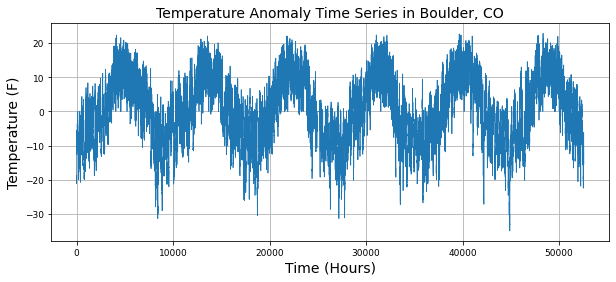

In [11]:
## Plot data
fig = plt.figure(figsize=(10,4))
plt.plot(data, lw=.75)
plt.ylabel(var_str+" ("+data_units+")",fontsize=14)
plt.xlabel('Time (Hours)',fontsize=14)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title(var_str+" Anomaly Time Series in Boulder, CO",fontsize=14)
plt.grid()
#plt.savefig('XX.pdf', dpi=300, format='png')

In [13]:
alpha = 0.99 ## set statistical significance level

##### METHOD #1 - Numpy Method - Calculate FFT
freq = np.fft.rfftfreq(len(data),d=1.) # Return the Discrete Fourier Transform sample frequencies
A = np.fft.rfft(data)
ps = (np.abs(A)**2)/2.
ps_n = (np.abs(A)**2)/np.sum(np.abs(A)**2)
Ao = ps[0]
red_fit_n = create_normalized_redfit(len(data),Te)
f_bounds = create_f_bounds(alpha,2*1,red_fit_n)
f_bounds_hanning = create_f_bounds(alpha,2*1*1.2,red_fit_n)  ## multiply DOF by 1.2 due to extra smoothing Hanning, Barnes Ch 4 Eq. 26

In [14]:
freq.shape

(26281,)

In [15]:
# Find the significant spectral peaks
for i in range(len(ps_n)):
    if (ps_n[i] - f_bounds[i]) > 1e-03:  
        #Question: why 1e-03?  This choice trying to select peaks that are well above 99% threshold.
        print('##### FOUND IT - spectral peak exceeds red noise ####')
        print('exceeds by...',ps_n[i]-f_bounds[i])
        print('at frequency....',freq[i])
        print('which in days is...',(1/freq[i])/24.)
        
## for reference -- what is 12-hourly, daily, and yearly in frequency?
print('XXXX FOR REFERENCE XXXX')
print('12-hourly in frequency:',round(1/12,3))
print('24-hourly/daily in frequency:',round(1/24,3))
print('yearly in frequency:',round(1/(24*365),5))  

##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.5433137086258512
at frequency.... 0.00011415525114155252
which in days is... 365.0
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.0338414208544037
at frequency.... 0.04166666666666667
which in days is... 0.9999999999999999
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.0016510217913104682
at frequency.... 0.08333333333333334
which in days is... 0.49999999999999994
XXXX FOR REFERENCE XXXX
12-hourly in frequency: 0.083
24-hourly/daily in frequency: 0.042
yearly in frequency: 0.00011


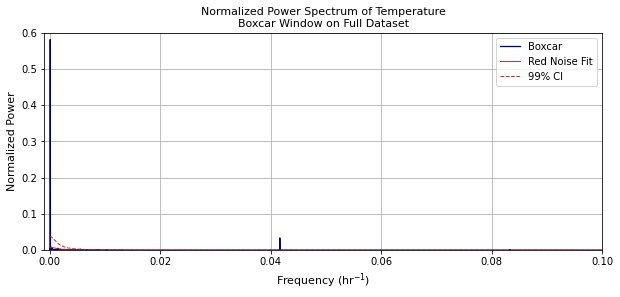

In [19]:
### Plot the results
fig = plt.figure(figsize=(10,4))
method_str = "Boxcar Window on Full Dataset"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.60)
plt.xlim(-0.001,0.1)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=11)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=11)
plt.legend(loc='upper right',fontsize=10)
plt.grid()

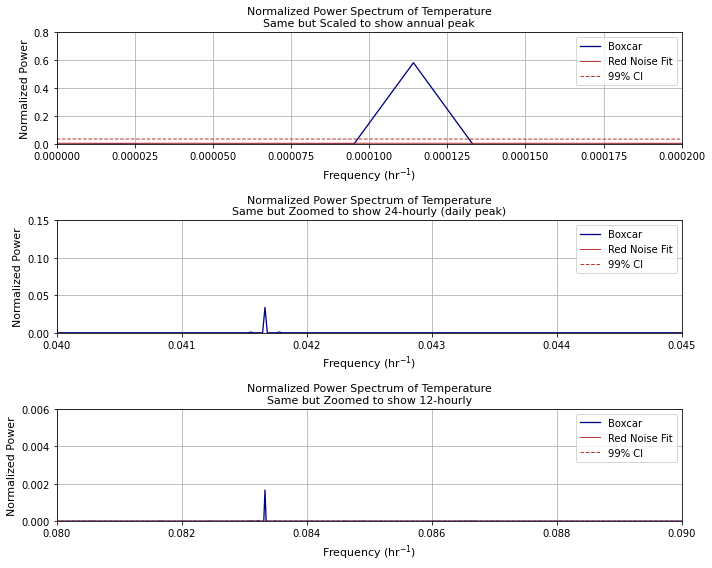

In [20]:
### Plot the results -- zoom in to get a better look at the three large peaks
fig = plt.figure(figsize=(10,8))
gs=GridSpec(3,1)
ax=plt.subplot(gs[0,0])
method_str = "Same but Scaled to show annual peak"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.8)
plt.xlim(0.0,0.0002)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=11)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=11)
plt.legend(loc='upper right',fontsize=10)
plt.grid()
ax=plt.subplot(gs[1,0])
method_str = "Same but Zoomed to show 24-hourly (daily peak)"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.15)
plt.xlim(0.04,0.045)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=11)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=11)
plt.legend(loc='upper right',fontsize=10)
plt.grid()
ax=plt.subplot(gs[2,0])
method_str = "Same but Zoomed to show 12-hourly"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.006)
plt.xlim(0.08,0.09)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=11)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=11)
plt.legend(loc='upper right',fontsize=10)
plt.grid()
fig.tight_layout()

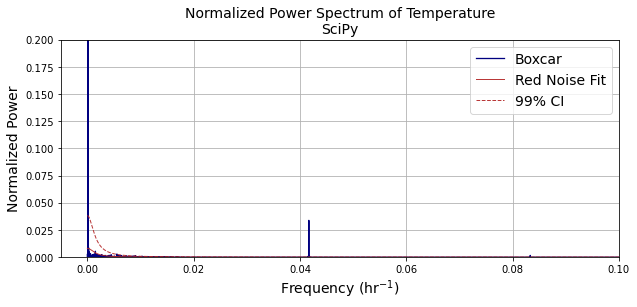

In [27]:
##### METHOD #2 - uses a different python function and library to do the same thing, not a different method mathematically.
## Calculate the power specra using the scipy method... let's see if we get the same answer - we should :).
## http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html#scipy.signal.periodogram
f,Pxx = signal.periodogram(data,fs=1.,window='boxcar',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_n = Pxx/np.sum(Pxx)

method_str = "SciPy"
fig = plt.figure(figsize=(10,4))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.2)
plt.xlim(-0.005,0.1)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()

In [28]:
# Find the significant spectral peaks
for i in range(len(Pxx_n)):
    if (Pxx_n[i] - f_bounds[i]) > 1e-03:  
        #Question: why 1e-03?  This choice trying to select peaks that are well above 99% threshold.
        print('##### FOUND IT - spectral peak exceeds red noise ####')
        print('exceeds by...',Pxx_n[i]-f_bounds[i])
        print('at frequency....',freq[i])
        print('which in days is...',(1/freq[i])/24.)
        
## for reference -- what is 12-hourly, daily, and yearly in frequency?
print('XXXX FOR REFERENCE XXXX')
print('12-hourly in frequency:',round(1/12,3))
print('24-hourly/daily in frequency:',round(1/24,3))
print('yearly in frequency:',round(1/(24*365),5))  

##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.5433137296205713
at frequency.... 0.00011415525114155252
which in days is... 365.0
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.03384142207827943
at frequency.... 0.04166666666666667
which in days is... 0.9999999999999999
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.00165102185137448
at frequency.... 0.08333333333333334
which in days is... 0.49999999999999994
XXXX FOR REFERENCE XXXX
12-hourly in frequency: 0.083
24-hourly/daily in frequency: 0.042
yearly in frequency: 0.00011


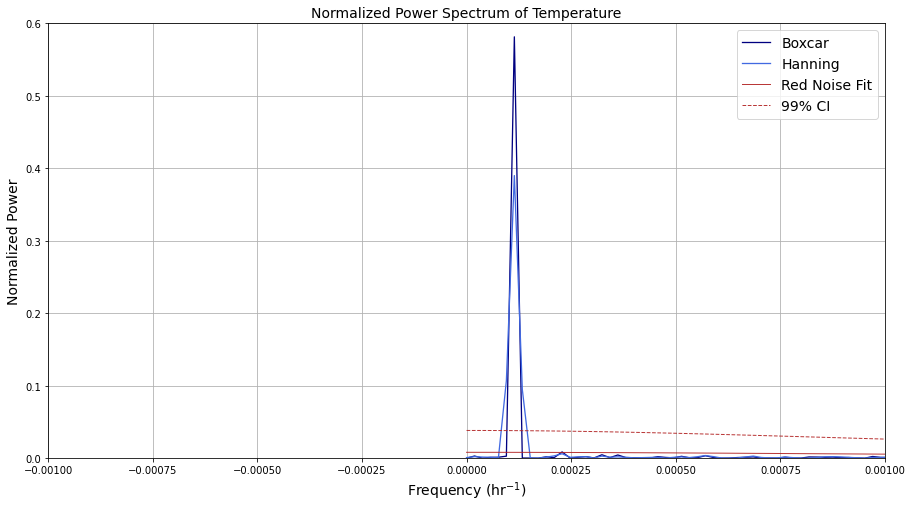

In [35]:
## Note: The benefit of the scipy function is that it has more options so we can for example
## compare results using a Boxcar and Hanning Window.
## You should see a broader peak with the tapered Hanning Window than with the sqaure Boxcar window.
## Can you explain why?  (refer back to lecture #10 of ATOC7500)
## Which window would you prefer??  (Jen prefers the Boxcar for its spectral accuracy... do you agree with her?)
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html#scipy.signal.periodogram

f,Pxx = signal.periodogram(data,fs=1.,window='boxcar',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_n = Pxx/np.sum(Pxx)
f_h,Pxx_h = signal.periodogram(data,fs=1.,window='hanning',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_h_n = Pxx_h/np.sum(Pxx_h)

fig = plt.figure(figsize=(15,8))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(f_h,Pxx_h_n, color='royalblue', lw=1.3, label='Hanning')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.6)
#plt.xlim(-0.001,0.1)
plt.xlim(-0.001,0.001)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum of "+var_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()

In [30]:
# Find the significant spectral peaks
for i in range(len(Pxx_h_n)):
    if (Pxx_h_n[i] - f_bounds[i]) > 1e-03:  
        #Question: why 1e-03?  This choice trying to select peaks that are well above 99% threshold.
        print('##### FOUND IT - spectral peak exceeds red noise ####')
        print('exceeds by...',Pxx_h_n[i]-f_bounds[i])
        print('at frequency....',freq[i])
        print('which in days is...',(1/freq[i])/24.)
        
## for reference -- what is 12-hourly, daily, and yearly in frequency?
print('XXXX FOR REFERENCE XXXX')
print('12-hourly in frequency:',round(1/12,3))
print('24-hourly/daily in frequency:',round(1/24,3))
print('yearly in frequency:',round(1/(24*365),5))  

##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.0690738330298577
at frequency.... 9.512937595129377e-05
which in days is... 437.99999999999994
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.351888283712178
at frequency.... 0.00011415525114155252
which in days is... 365.0
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.05688633752306061
at frequency.... 0.0001331811263318113
which in days is... 312.85714285714283
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.0054762214227043835
at frequency.... 0.04164764079147641
which in days is... 1.0004568296025582
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.022461559549132065
at frequency.... 0.04166666666666667
which in days is... 0.9999999999999999
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.005493601166149269
at frequency.... 0.04168569254185693
which in days is... 0.9995435874030122
XXXX FOR REFERENCE XX

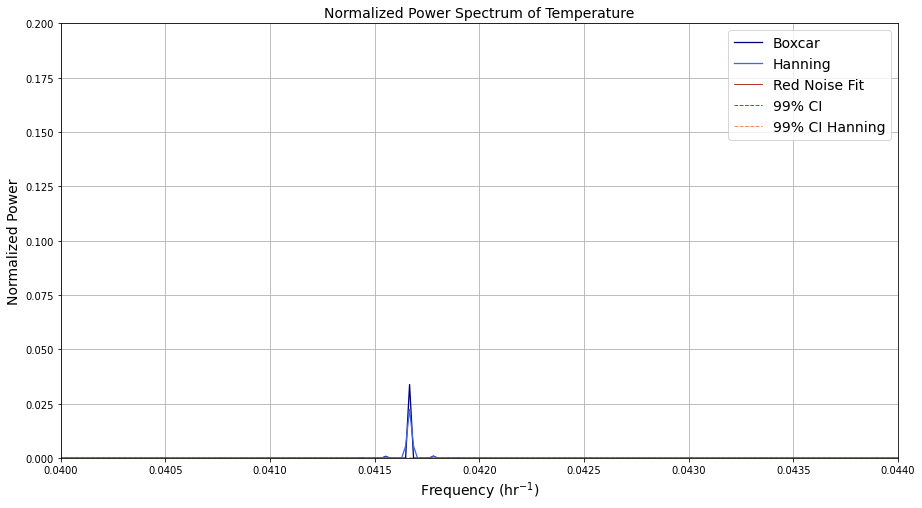

In [24]:
### You need to zoom in to see the extra smoothing caused by the Hanning Window.
fig = plt.figure(figsize=(15,8))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(f_h,Pxx_h_n, color='royalblue', lw=1.3, label='Hanning')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.plot(freq,f_bounds_hanning, color='coral', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI Hanning')

plt.ylim(0.0,0.20)
plt.xlim(0.04,0.044)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum of "+var_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()

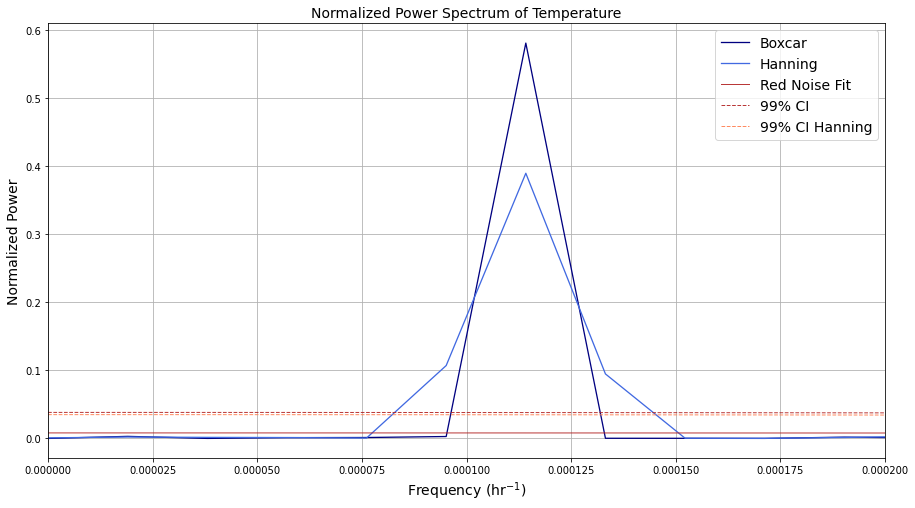

In [25]:
### You need to zoom in to see the extra smoothing caused by the Hanning Window.
### ##### FOUND IT - spectral peak exceeds red noise ####
##exceeds by... 0.04849019553988333
##at frequency.... 0.00011415525114155251
##which in days is... 365.0

fig = plt.figure(figsize=(15,8))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(f_h,Pxx_h_n, color='royalblue', lw=1.3, label='Hanning')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.plot(freq,f_bounds_hanning, color='coral', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI Hanning')
#plt.ylim(0.0,0.40)
plt.xlim(0.00,0.0002)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum of "+var_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()

### Notes:

1. For surface temperature, the autocorrelation is 0.99 and the e-folding time is 106.94 hours. I expect two strong spectral peaks at 1/24(hr^-1) , representing diurnal cycle, and 1/(24*365)(hr^-1), representing seasonal cycle. Some weaker peaks may be found that are related to large scale modes of variability.

2. Numpy method (Boxcar window): Three statistically significant spectral peaks were found at frequeny 0.00011, 0.042, and 0.083, representing seasonal cycle, diurnal cycle and half-day cycle, respectively. Not sure about the half-day cycle in the result, I guess it is more likely due to some kind of spectral ringing artifact than atmospheric tides. The statistical significance was assessed using the f-statistic. The null hypothesis is that the peak at a frequency is just random fluctuations of a red noise time series. Compare the ratio of the variances (height) of the original spectrum and the red-noise fit to the 99% level f-statistic. If higher than the f-statistic, then we can reject the null hypothesis. 

3. Scipy method: The same result was found. Assume a window length that is the entire length of the dataset. When using the Hanning window, the statistically significant peaks for seasonal and diurnal cycles were found, but there was no half-day cycle. Also, the yearly and diurnal cycle peaks are lower and broader than those by using the Boxcar window. These differences are caused by the extra smoothing of the Hanning window. 

4. Other surface meteorological variables: For surface pressure, relative humidity, and wind speed, instead of the seasonal and diurnal cycle peaks, some other statistically significant spectral peaks were found. For example, for surface pressure, there were many other statistically significant spectral peaks at frequencies of 3-7 days. Among these variables, surface temperature has the  largest spectral power at diurnal and seasonal frequencies.